In [1]:
# Start writing code here...

In [2]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from  sklearn.svm import SVR

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

import xgboost
from xgboost import XGBRegressor

from lib.viz import draw_histogram, create_silhoutte_cluster_viz, create_feature_importance_charts
from lib.unsupervised import kmeans_parameters_search

from lib.supervised_tuning import compare_models_manual, read_target_shifted_data, FeatureTTRegressor, final_comparison, add_cluster_label, print_scores, predict_score_base_regressors, predict_mean_squared_error_regression

from matplotlib import pyplot as plt
from xgboost import plot_importance

from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline


/shared-libs/python3.9/py/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
RANDOM_SEED = 42

## Load numpy arrays and dataframes from pickle files

In [4]:
data_dir = "../assets/train_test_target_shifted/"
train_test_dict_file_name = "train_test_dict_target_shifted.pickle"
X_train_df_file_name = "X_train_impute_target_shifted_df.pkl"
X_test_df_file_name = "X_test_impute_target_shifted_df.pkl"

train_test_dict, X_train_impute_df, X_test_impute_df = read_target_shifted_data(
    data_dir, train_test_dict_file_name, X_train_df_file_name, X_test_df_file_name
)
X_train_impute = train_test_dict["X_train_impute"]
X_test_impute = train_test_dict["X_test_impute"]
y_train_df = train_test_dict['y_train']
y_test_df = train_test_dict['y_test']
y_train = y_train_df['GSE_GWE_SHIFTED'].values.ravel()
y_test = y_test_df['GSE_GWE_SHIFTED'].values.ravel()



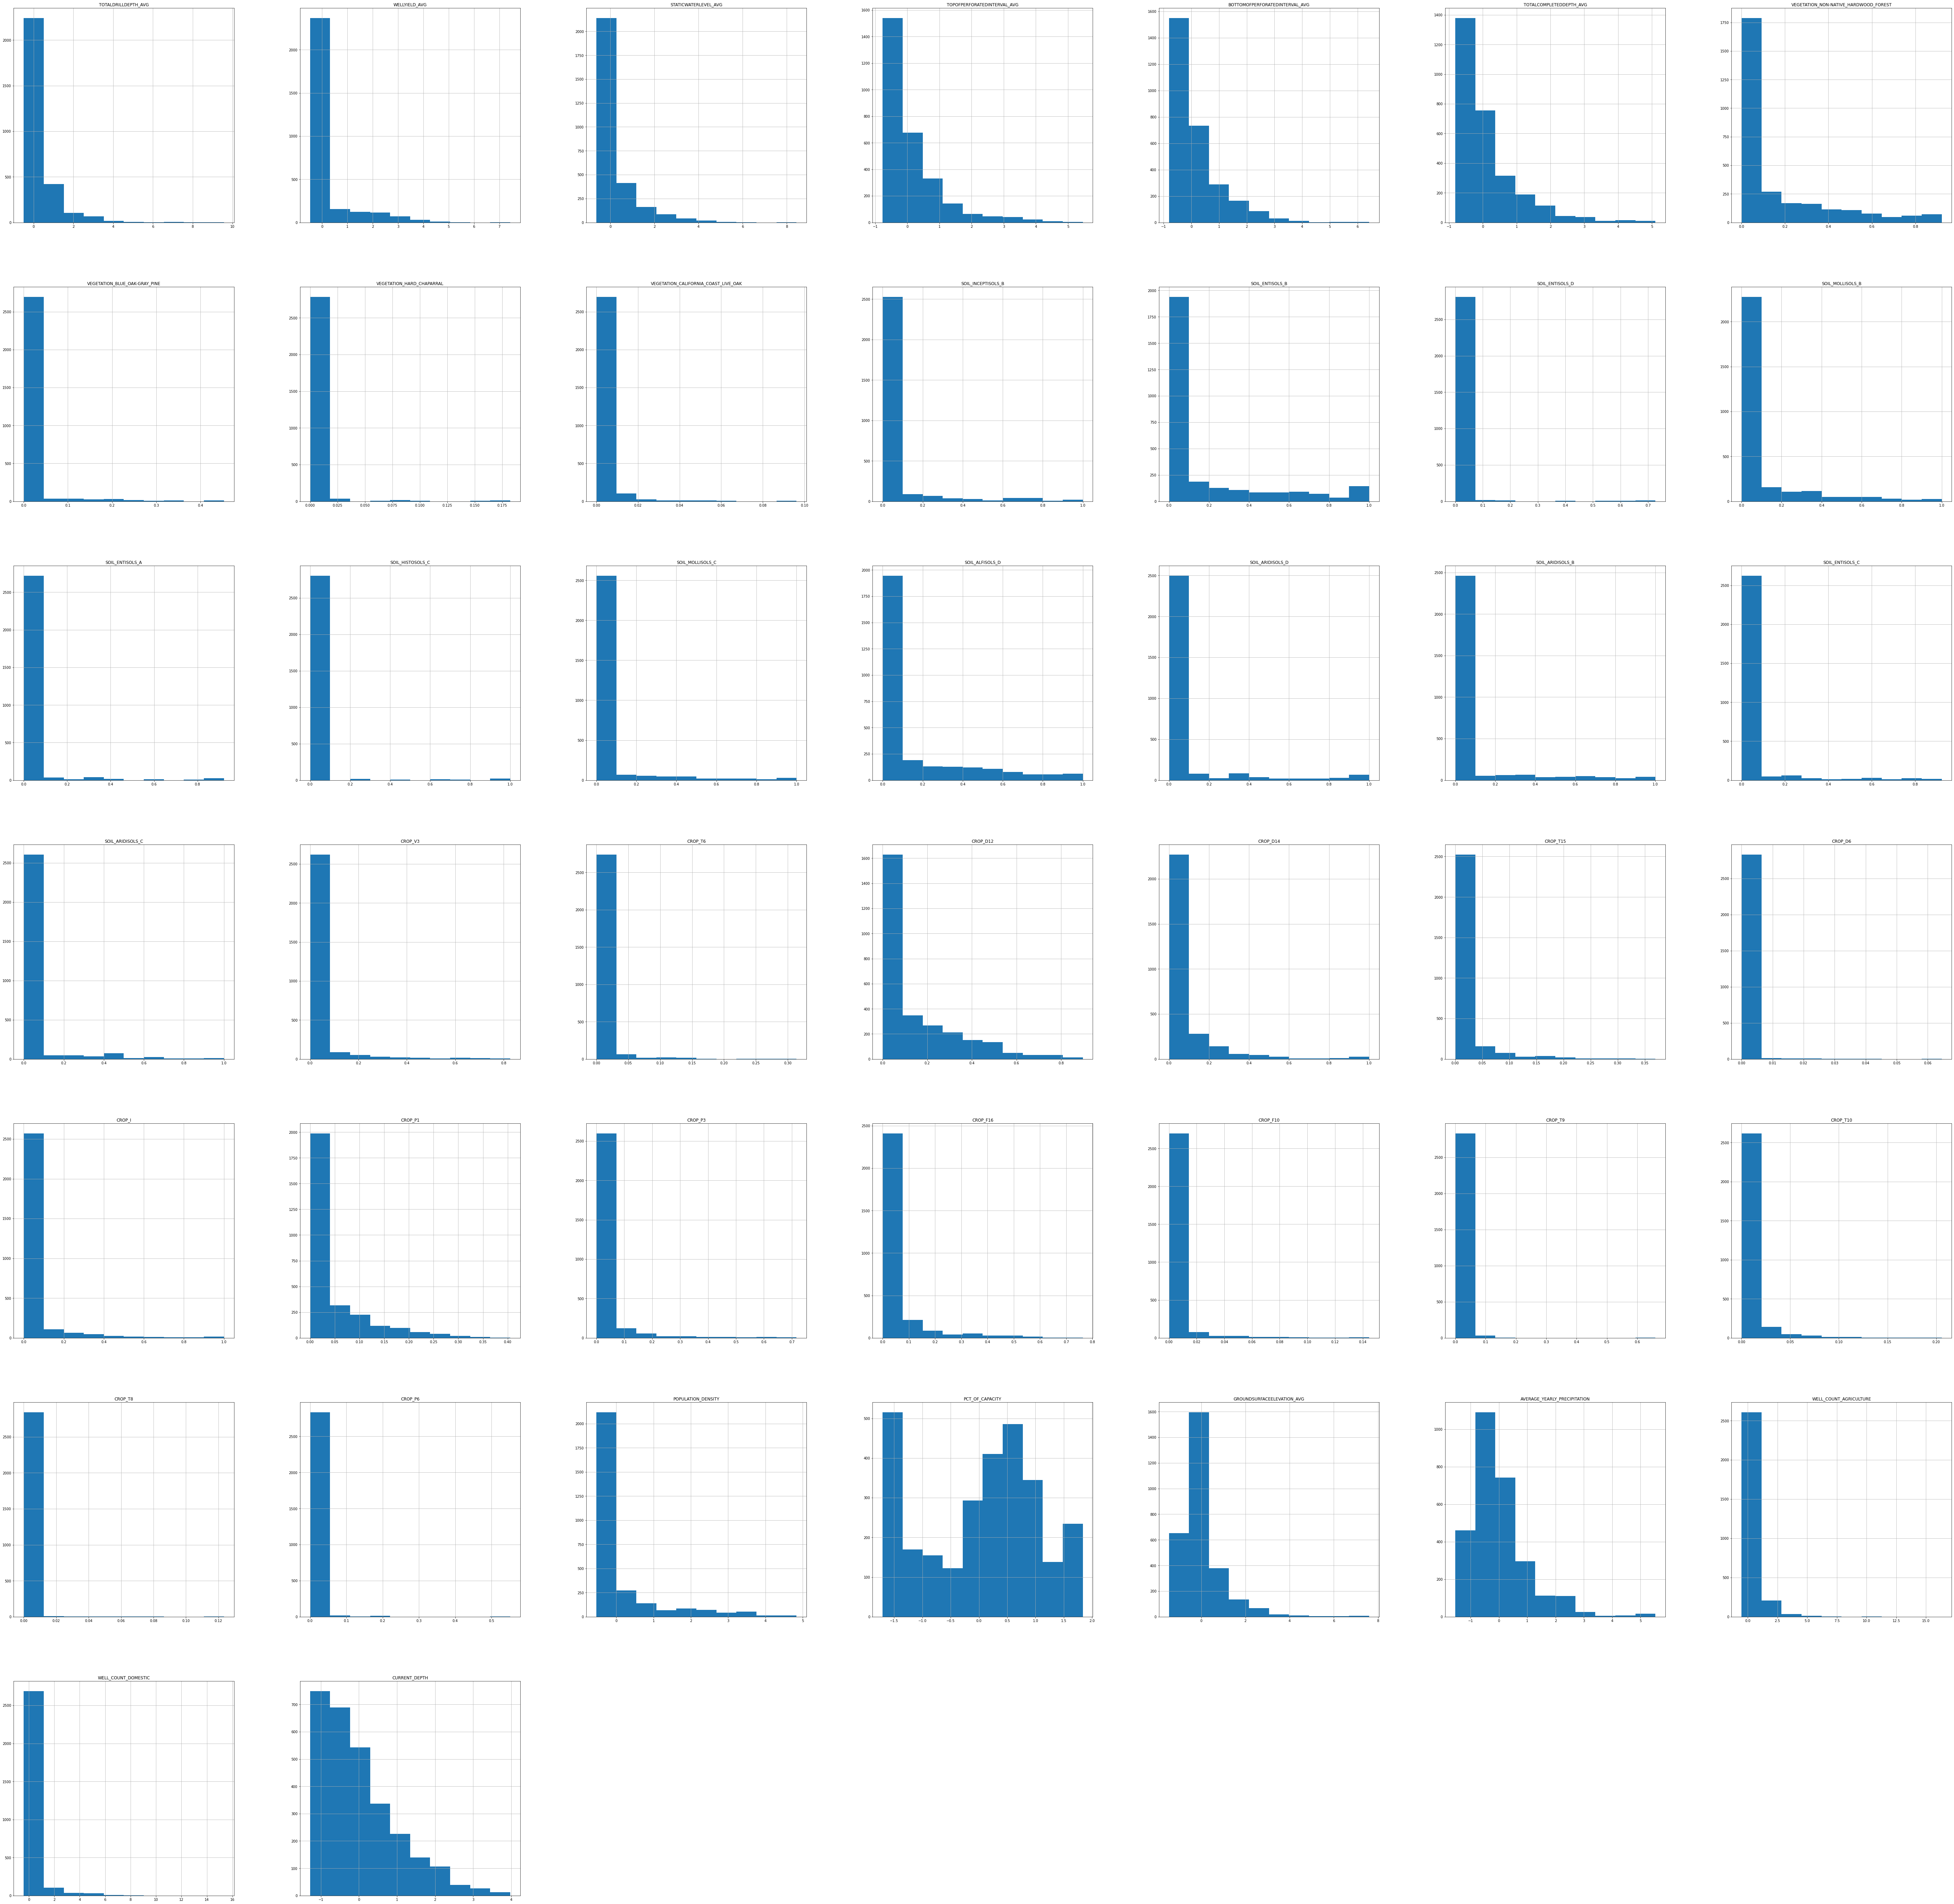

In [5]:
_= X_train_impute_df.hist(figsize=(100, 100))

## [Understand the distribution of the target](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

In [6]:
draw_histogram(pd.DataFrame(y_train_df.reset_index()), "GSE_GWE_SHIFTED" ) 

alt.LayerChart(...)

## [Normalize the target to improve accuracy](https://anshikaaxena.medium.com/how-skewed-data-can-skrew-your-linear-regression-model-accuracy-and-transfromation-can-help-62c6d3fe4c53)




In [7]:
#We will view the variables with sqrt applied but we do not need these in the model since 
# we will be using TransformedTargetRegressor to wrap models to aid with Cross Validations
y_train_sqrt = np.sqrt(train_test_dict['y_train'])
y_test_sqrt = np.sqrt(train_test_dict['y_test'])
draw_histogram(pd.DataFrame(y_train_sqrt.reset_index()), "GSE_GWE_SHIFTED" ) 

alt.LayerChart(...)

### Baseline
   - Distribution of the target and statistics such as mean and median 
   - It can be observed below that the target has a [left skewed distribution](https://stats.stackexchange.com/questions/11351/left-skewed-vs-symmetric-distribution-observed/11352#11352) with most well of the groundwater depth less that 200
   - The score of this regressor is very low : R-squared of the prediction = -0.057
   - The r-squared is negative and this indicates that the the sum-of-squares of the residuals from the model (SSres) is larger than the sum-of-squares from the horizontal line (median) (SStot).
   - R-squared is computed as 1−SSres/SStot. (here, SSres = residual error)When SSres is greater than SStot, that equation could compute a negative value for R-squared, if the value of the coefficient is greater than 1.
   - In the manual section of the analysis, the scores for target normalized and the scores for target not normalizzed are compared. After several iterations it was concluded that normaizing the target improves the evaluation metrics. 
   - Instead of continulaly performing an inverse_transform, a wrapper class available in sklearn called TransformedTargetRegressor is used to wrap the model and this accpets both the transformation and the inverse transformation function. It also aids in cross validation pipelines as it internally performs the transformation and the metrics do not need to be manually converted back to the original scale.


## Unnormalized data dummy score

In [8]:
regressor_dict = {"Dummy Regressor": DummyRegressor(strategy="median"),
                 "Linear Regressor" : LinearRegression(),
                 "Ridge Regressor" : Ridge(),
                 "Lasso Regressor": Lasso()
}

for reg_name in regressor_dict.keys():
    model = regressor_dict[reg_name].fit(X_train_impute, y_train)
    predict_mean_squared_error_regression(model, X_train_impute, y_train, reg_name)


Prediction from Dummy Regressor is : [136.799375 136.799375 136.799375 ... 136.799375 136.799375 136.799375]
Scores from Dummy Regressor : R2 score:-0.05491127456489808;  MSE score:17536.940944080314; RMSE score:132.42711559223932
Prediction from Linear Regressor is : [ 69.75062454  66.49552591  56.07768657 ... 367.33954782 383.85004998
 389.35408398]
Scores from Linear Regressor : R2 score:0.8677010468244882;  MSE score:2199.349826609388; RMSE score:46.897226214450974
Prediction from Ridge Regressor is : [ 68.9070303   65.75827631  55.6425229  ... 366.44478597 384.35238882
 389.71616036]
Scores from Ridge Regressor : R2 score:0.8669745631909709;  MSE score:2211.426956587063; RMSE score:47.02581159945103
Prediction from Lasso Regressor is : [ 63.61567724  61.75830487  53.5097709  ... 360.67522094 380.71071248
 386.04960243]
Scores from Lasso Regressor : R2 score:0.8628949283669091;  MSE score:2279.2471768349633; RMSE score:47.741461821303325


## Normalized data dummy score

In [9]:
regressor_dict = {"Dummy Regressor": DummyRegressor(strategy="median"),
                 "Linear Regressor" : LinearRegression(),
                 "Ridge Regressor" : Ridge(),
                 "Lasso Regressor": Lasso()
}

for reg_name in regressor_dict.keys():
    tt = TransformedTargetRegressor(regressor=regressor_dict[reg_name],
                                 func=np.sqrt, inverse_func=np.square)
    model = tt.fit(X_train_impute, y_train)
    predict_mean_squared_error_regression(model, X_train_impute, y_train, reg_name)


Prediction from Dummy Regressor is : [136.799375 136.799375 136.799375 ... 136.799375 136.799375 136.799375]
Scores from Dummy Regressor : R2 score:-0.054911274567492896;  MSE score:17536.94094412345; RMSE score:132.42711559240217
Prediction from Linear Regressor is : [ 66.66405412  64.07160867  58.50775514 ... 320.95494311 348.60077306
 354.32572825]
Scores from Linear Regressor : R2 score:0.8281578258293067;  MSE score:2856.7199278221537; RMSE score:53.448292094529585
Prediction from Ridge Regressor is : [ 65.81829613  63.21225718  57.91469666 ... 319.01052374 345.44307107
 350.69982796]
Scores from Ridge Regressor : R2 score:0.8243886347094365;  MSE score:2919.3793037050973; RMSE score:54.03128078904939
Prediction from Lasso Regressor is : [ 79.58259694  79.08390819  75.60523383 ... 321.45377585 342.06816823
 349.9399457 ]
Scores from Lasso Regressor : R2 score:0.7986030192234104;  MSE score:3348.0417200506936; RMSE score:57.86226507881189


## Using Unsupervised Learning to instrument feature to improve Supervised Learning

- Both Silhouette score (closer to 1 is better) and  davies_bouldin_score (lower is better) emphasize the distance between clusters 
- intertia tries to minimize the distane from point to center (lower is better) 
- For this dataset the davies_bouldin_score as well as inertia drops with the rise in number of clusters but silhouette score is higher at k=2

In [10]:
# Assume the number of clusters
kmeans_score_df = kmeans_parameters_search(X_train_impute, random_seed= RANDOM_SEED)
print (f"Top clustering Scores : {kmeans_score_df.loc[0]}")

Top clustering Scores : k                              2.000000
davies_bouldin_score           1.791581
calinski_harabasz_score      748.402044
silhouette_score               0.264756
inertia                    30796.346322
Name: 0, dtype: float64


## [Silhouette Score Visualization](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as)
1.  near +1 indicate that the sample is far away from the neighboring clusters. 
2. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and 
3. negative values indicate that **those samples might have been assigned to the wrong cluster.**
4. Also from the thickness of the silhouette plot the cluster size can be visualized. 

For n_clusters = 2 The average silhouette_score is : 0.2860206664802614
For n_clusters = 3 The average silhouette_score is : 0.1884016088711663
For n_clusters = 4 The average silhouette_score is : 0.17939489883582552
For n_clusters = 5 The average silhouette_score is : 0.1655093587202436
For n_clusters = 6 The average silhouette_score is : 0.16326482242151616


<module 'matplotlib.pyplot' from '/shared-libs/python3.9/py/lib/python3.9/site-packages/matplotlib/pyplot.py'>

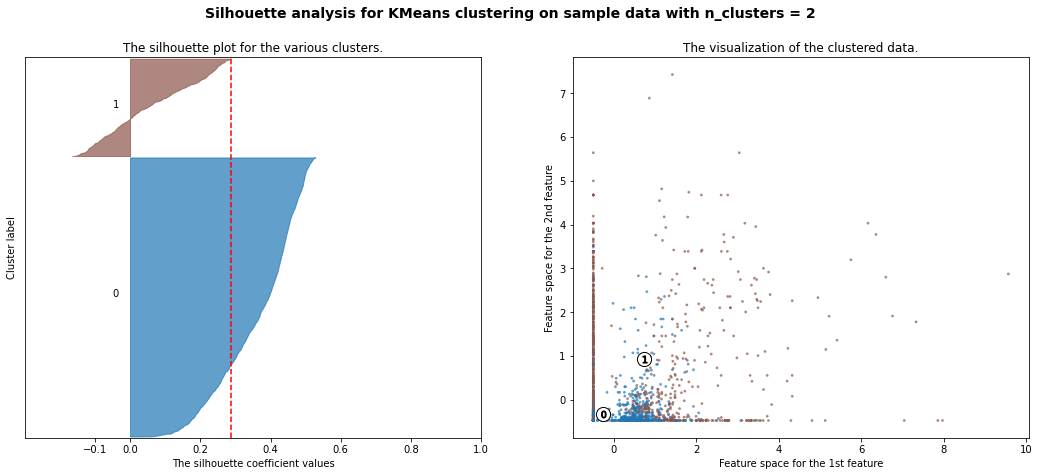

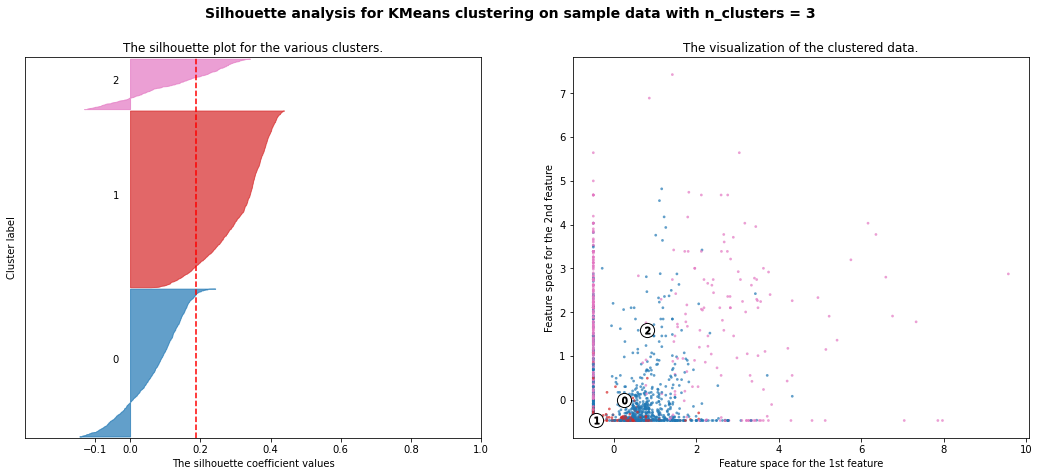

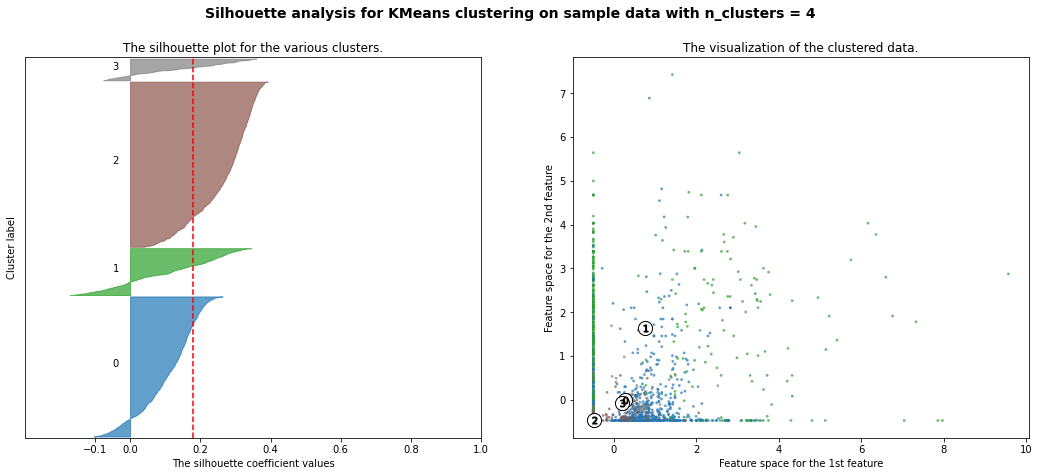

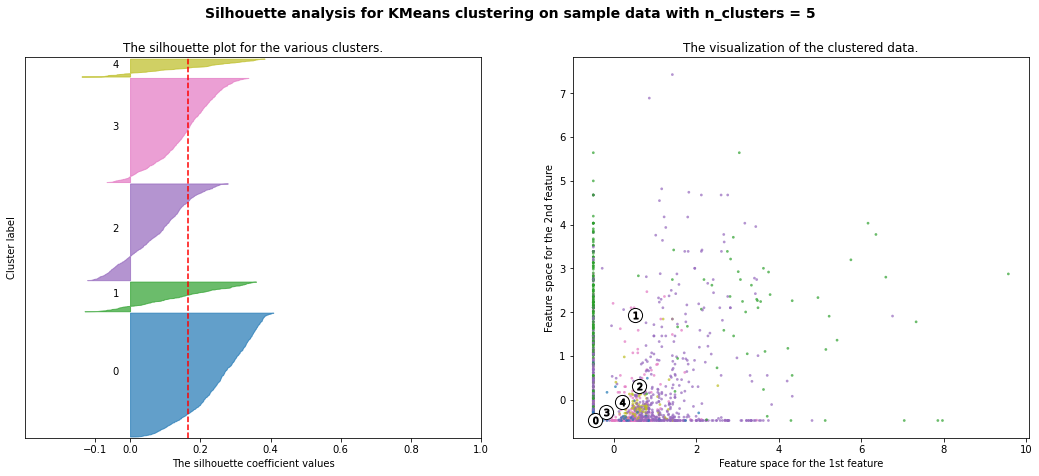

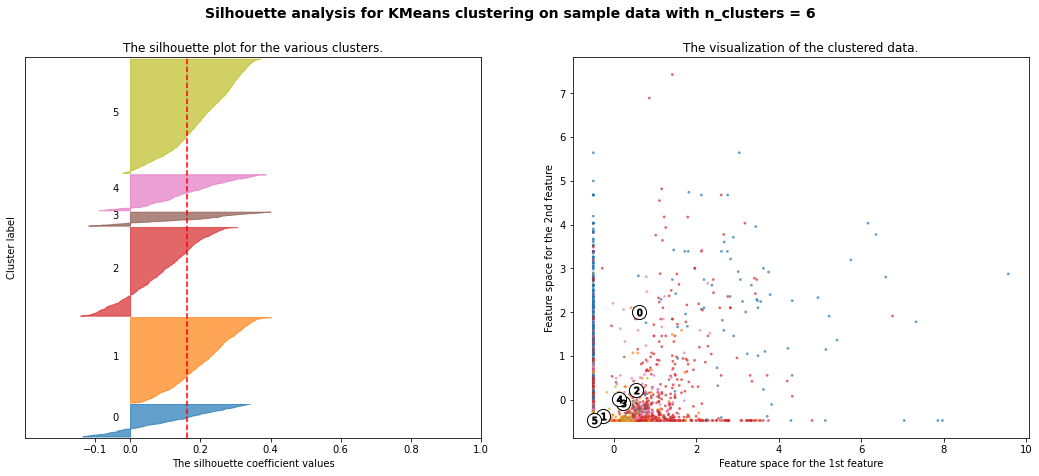

In [11]:
create_silhoutte_cluster_viz(X_train_impute, RANDOM_SEED)

### Observations from clustering scores and visualizations

1. The scores indicate that 2 or 3 clusters will provide the best scores. The Silhouette score is low ~0.22 
2. The visualization show that the second cluster onwards, the data points are so scattered that they may have been incorrectly assigned  into a cluster.This causes the score to be negative and so we see negative scores for clusters more than 1.
3. The clusters are not evenly sized (thickness along Y-axis)
4. Our dataset has one main cluster and the other clusters are not definitive. This might be because we have taken into account data from only teh agricultural San Joaquin valley in California. If our dataset included a larger geogrpahy, say all of California, it is likely our clusters would be ore defined.


### Observations from clustering on the training set

1. The clusters do not include all years of a township range. There is no pattern as to which Township-Range and years are included in a cluster
2. We used the clusters from the unsupervised learning as feature in supervised learning, but since it did not improve scores, it is not featured in this study below





### Random searching to narrow down possibilities to provide to GridSearch

Regularization and Generalization for [Lasso](https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression)

When it comes to training models, there are two major problems one can encounter: overfitting and underfitting.

- Overfitting happens when the model performs well on the training set but not so well on unseen (test) data.
- Underfitting happens when it neither performs well on the train set nor on the test set.
Particularly, regularization is implemented to avoid overfitting of the data, especially when there is a large variance between train and test set performances. With regularization, the number of features used in training is kept constant, yet the magnitude of the coefficients is reduced.


**Ridge and Lasso** 

**Lasso Regression for Model Selection**
Lasso is short for Least Absolute Shrinkage and Selection Operator, which is used both for regularization and model selection. If a model uses the L1 regularization technique, then it is called lasso regression. 
Due to the fact that coefficients will be shrunk towards a mean of zero, less important features in a dataset are eliminated when penalized. The shrinkage of these coefficients based on the alpha value provided leads to some form of automatic feature selection, as input variables are removed in an effective approach.

**Ridge regression** puts a similar constraint on the coefficients by introducing a penalty factor. However, while lasso regression takes the magnitude of the coefficients, ridge regression takes the square.
Minimizes objective function:
||y - Xw||^2_2 + alpha * ||w||^2_2


**Scores**
[Negative Mean Absolute Error](https://stackoverflow.com/questions/55786121/what-is-the-negative-mean-absolute-error-in-scikit-learn#:~:text=As%20its%20name%20implies%2C%20negative,than%20a%20value%20of%20%2D3.0%20.) Smaller the better

### MODEL COMPARISON
#### Create regressors and parameter grids for comparisons



In [12]:
xgb_grid = {
    "regressor__n_estimators": [200, 250],
    "regressor__max_depth": [2, 3],
    "regressor__min_child_weight": [7, 9],
    "regressor__tree_method": ["auto", "exact"],
    "regressor__learning_rate": [0.1, 0.2, 0.3],
    "regressor__gamma": [1.0, 2.0],
    "regressor__reg_lambda": [50.0, 100.0, 150.0],
}
svr_grid = [
    {
        "regressor__C": [10, 100],
        "regressor__gamma": ["scale",  0.1, 0.01, 0.001],
        "regressor__kernel": [ "rbf"],
    }
]

knn_grid = {"regressor__n_neighbors": [10, 20, 30, 40, 50]}

# Create the parameter grid
gbr_grid = {
    "regressor__n_estimators": [200, 300],
    "regressor__max_depth": [2, 5],
    "regressor__min_samples_split": [5, 10, 20],
    "regressor__min_samples_leaf": [10, 20],
    "regressor__learning_rate": [0.01, 0.05, 0.1],
}
cat_grid = {
    "regressor__depth": [4, 6, 8],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__iterations": [50, 100],
}

rf_grid = {"regressor__max_depth":[5, 7],
           "regressor__n_estimators" :[150, 200]}


base_model_param_dict = {
    "XGBRegressor": [XGBRegressor(), xgb_grid],
    "SupportVectorRegressor": [SVR(), svr_grid],
    "KNearestNeighbors": [KNeighborsRegressor(), knn_grid],
    "GradientBoostingRegressor": [GradientBoostingRegressor(), gbr_grid],
    "CatBoostRegressor": [CatBoostRegressor(), cat_grid],
    "RandomForestRegressor": [RandomForestRegressor(), rf_grid]
}


In [13]:
models, best_params_dict = compare_models_manual(base_model_param_dict, X_train_impute, y_train, RANDOM_SEED)
best_params_dict

Fitting 3 folds for each of 50 candidates, totalling 150 fits
/root/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Fitting 3 folds for each of 8 candidates, totalling 24 fits
/root/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
/root/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Fitting 3 folds for each of 18 candidates, totalling 54

{'XGBRegressor': {'regressor__tree_method': 'exact',
  'regressor__reg_lambda': 100.0,
  'regressor__n_estimators': 200,
  'regressor__min_child_weight': 7,
  'regressor__max_depth': 2,
  'regressor__learning_rate': 0.1,
  'regressor__gamma': 2.0},
 'SVR': {'regressor__kernel': 'rbf',
  'regressor__gamma': 0.01,
  'regressor__C': 10},
 'KNeighborsRegressor': {'regressor__n_neighbors': 10},
 'GradientBoostingRegressor': {'regressor__n_estimators': 200,
  'regressor__min_samples_split': 20,
  'regressor__min_samples_leaf': 10,
  'regressor__max_depth': 2,
  'regressor__learning_rate': 0.05},
 'CatBoostRegressor': {'regressor__learning_rate': 0.05,
  'regressor__iterations': 100,
  'regressor__depth': 4},
 'RandomForestRegressor': {'regressor__n_estimators': 150,
  'regressor__max_depth': 5}}

In [14]:
final_comparison(models, X_train_impute, y_train)

,XGBRegressor,SVR,KNeighborsRegressor,GradientBoostingRegressor,CatBoostRegressor,RandomForestRegressor
Mean Absolute Error,22.9395,24.6301,30.8445,23.1710,24.5741,22.9775
Mean Squared Error,1743.2893,2335.3332,2260.0457,1823.2959,1984.4531,1656.4376
R^2,0.8951,0.8595,0.8640,0.8903,0.8806,0.9004
RMSE,41.7527,48.3253,47.5399,42.7001,44.5472,40.6994


In [15]:
final_comparison(models, X_test_impute, y_test)

,XGBRegressor,SVR,KNeighborsRegressor,GradientBoostingRegressor,CatBoostRegressor,RandomForestRegressor
Mean Absolute Error,32.0977,28.9121,54.1012,32.6342,32.0168,30.7058
Mean Squared Error,2892.9006,2040.4726,5815.4869,2436.2878,2778.2086,2530.6664
R^2,0.8275,0.8783,0.6532,0.8547,0.8343,0.8491
RMSE,53.7857,45.1716,76.2593,49.3588,52.7087,50.3057


In [16]:

chart_list = create_feature_importance_charts(models, X_train_impute_df)

In [17]:
for chart in chart_list:
    display(chart)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [18]:
###########################################################################

### MANUAL EXPERIMENTATION ON SINGLE ALGORITHM LEVEL 

#### Unnormalized RandomForest

In [19]:
rfreg = RandomForestRegressor(
    max_depth=7, n_estimators=200, random_state=RANDOM_SEED
).fit(X_train_impute, y_train)
print(f"Train set score: {rfreg.score(X_train_impute, y_train)}")
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py
print(
    f"Test set score:{rfreg.score(X_test_impute, y_test)}"
)  # without duration = -0.601225986040484


Train set score: 0.9367663816908643
Test set score:0.8144057123947007


#### Normalized RandomForest

In [20]:
rfreg = RandomForestRegressor(
    max_depth=7, n_estimators=200, random_state=RANDOM_SEED
)
tt = TransformedTargetRegressor(regressor=rfreg, func=np.sqrt, inverse_func=np.square).fit(X_train_impute, y_train)

print_scores(tt, X_train_impute, y_train, "Random Forest")
print_scores(tt, X_test_impute, y_test, "Random Forest")


Scores from Random Forest : R2 score:0.9323440110631603;  MSE score:1124.7193115725079; RMSE score:33.536835145441316
Scores from Random Forest : R2 score:0.8140634425218802;  MSE score:3117.5585039995285; RMSE score:55.83510100285956


####  Normalized Linear Regression

In [21]:

# random search linear regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.model_selection import RepeatedKFold


model = TransformedTargetRegressor(regressor=Lasso(), func=np.sqrt, inverse_func=np.square)
#print(model.get_params().keys())

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
# define search space
space = dict()

space["regressor__alpha"] =  [ 1,0.1,0.01,0.001,0.0001]    #loguniform(1e-5, 100)
space["regressor__fit_intercept"] = [True, False]
# define search
search = RandomizedSearchCV(
    model,
    space,
    n_iter= 100,  #500,
    scoring= 'r2',    #"neg_median_absolute_error",‘neg_root_mean_squared_error’
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_SEED,
)
# execute search
train_result = search.fit(X_train_impute, y_train)
# summarize result
print("Best Score: %s" % train_result.best_score_)
print("Best Hyperparameters: %s" % train_result.best_params_)

# Best Score: 0.5152586321281089
# Best Hyperparameters: {'regressor__fit_intercept': False, 'regressor__alpha': 0.0001}


/root/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Best Score: 0.8219317899762741
Best Hyperparameters: {'regressor__fit_intercept': True, 'regressor__alpha': 0.0001}


####  Support Vector Machine Regressor

- We will be choosing the parameters first in this case and then run the regression with chosen parameters

In [22]:
def search_svm_params(y_train:np.ndarray):
    ## Commenting out code since the best parameters have been found
    param_grid = [
        {
            "C": [0.5, 1, 10, 100],
            "gamma": ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
            "kernel": ["linear", "rbf"],
        }
    ]

    optimal_params = GridSearchCV(
        SVR(),
        param_grid,
        cv=5,
        scoring='r2',
        verbose=0
    )

    optimal_params.fit(X_train_impute, y_train)
    print(f"UnnormalizedNormalized Target Best Params = {optimal_params.best_params_}")

    optimal_params.fit(X_train_impute, np.sqrt(y_train))
    print(f"Normalized Target Best Params = {optimal_params.best_params_}")



In [23]:
#search_svm_params(y_train)
#Unnormalized{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
#Normalized Target Best Params = {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

####  Unnormalized SVM

In [24]:
svmreg = SVR(C= 0.5, gamma='scale', kernel= 'linear')
svmreg.fit(X_train_impute, y_train)
print_scores (svmreg, X_train_impute, y_train, "Unnormalized Train SVM")
print_scores (svmreg, X_test_impute, y_test, "Unnormalized Test SVM")




Scores from Unnormalized Train SVM : R2 score:0.861875195216611;  MSE score:2296.19931344273; RMSE score:47.918673953300605
Scores from Unnormalized Test SVM : R2 score:0.8890149061352155;  MSE score:1860.8633390239088; RMSE score:43.13772524164793


####  Normalized SVM

In [25]:
#Normalized Target Best Params = {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
svmreg = SVR(C=100, gamma= 0.01, kernel= 'rbf')
tt = TransformedTargetRegressor(regressor=svmreg, func=np.sqrt, inverse_func=np.square).fit(X_train_impute, y_train)
print_scores (tt, X_train_impute, y_train, "Train Set Normalized SVM")
print_scores (tt, X_test_impute, y_test, "Test Set Normalized SVM")


Scores from Train Set Normalized SVM : R2 score:0.8832566319221614;  MSE score:1940.752365584975; RMSE score:44.05397105352677
Scores from Test Set Normalized SVM : R2 score:0.8537720470661179;  MSE score:2451.772821733092; RMSE score:49.51537964847984


##### Normalized target with SVM shows better training score but a lower test score 

####  SVM on the PCA data with normalized target

In [26]:
with open("../assets/train_test_target_shifted/X_target_shifted_pca.pickle", "rb") as file:
    pca_train_test_dict = pickle.load(file)
X_train_pca = pca_train_test_dict["X_train_pca"]
X_test_pca = pca_train_test_dict["X_test_pca"]


In [27]:
## Commenting out code since the best parameters have been found
# tt = TransformedTargetRegressor(regressor=SVR(), func=np.sqrt, inverse_func=np.square )
# param_grid = [
#     {
#         'regressor__C': [0.5, 1, 10, 100],
#         'regressor__gamma': ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
#         "regressor__kernel": ["linear", "rbf"],
#     }
# ]

# optimal_params = GridSearchCV(
#     tt,
#     param_grid,
#     cv=5,
#     scoring='r2',
#     verbose=0
# )
#optimal_params.fit(X_train_pca, y_train)


#{'regressor__C': 100, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}

####  Unnormalized target with PCA

In [28]:
svmreg = SVR(C=100, gamma= 'scale', kernel= 'rbf')
svmreg = svmreg.fit(X_train_pca, y_train)
print_scores (svmreg, X_train_pca, y_train, "Train Set Normalized SVM")
print_scores (svmreg, X_test_pca, y_test, "Test Set Normalized SVM")


Scores from Train Set Normalized SVM : R2 score:0.8197744211139532;  MSE score:2996.086410054623; RMSE score:54.73651806659447
Scores from Test Set Normalized SVM : R2 score:0.7410139444984971;  MSE score:4342.363818589121; RMSE score:65.89661462161104


####  Normalized target with PCA

In [29]:
svmreg = SVR(C=100, gamma='scale', kernel= 'rbf')
tt = TransformedTargetRegressor(regressor=svmreg,
                                 func=np.sqrt,
                                 inverse_func=np.square).fit(X_train_pca, y_train)
print_scores (tt, X_train_pca, y_train, "Train Set Normalized SVM")
print_scores (tt, X_test_pca, y_test, "Test Set Normalized SVM")

# Scores from Train Set Normalized SVM : R2 score:0.8505500716598298;  MSE score:2484.4691971650386; RMSE score:49.84445001366791
# Scores from Test Set Normalized SVM : R2 score:0.7467706145287163;  MSE score:4245.842963030414; RMSE score:65.16013323367605


Scores from Train Set Normalized SVM : R2 score:0.8505500716598298;  MSE score:2484.4691971650386; RMSE score:49.84445001366791
Scores from Test Set Normalized SVM : R2 score:0.7467706145287163;  MSE score:4245.842963030414; RMSE score:65.16013323367605


### PCA normalized shows improved in training score as well 

####  Unnormalized with cluster feature

In [30]:
# 14 clusters (best davies_bouldin_score) gives a marginally better train score than 2 clusters  and same score for test set
X_train_cluster_df, X_test_cluster_df = add_cluster_label(
    X_train_impute_df, X_test_impute_df, n_clusters=2, random_seed=RANDOM_SEED
)

In [31]:
svmreg = SVR(C=100, gamma=0.01, kernel="rbf")
svmreg.fit(X_train_cluster_df.values, y_train)
print_scores (svmreg, X_train_cluster_df, y_train, "Training Normalized SVM")
print_scores (svmreg, X_test_cluster_df, y_test, "Testing Normalized SVM")


Scores from Training Normalized SVM : R2 score:0.8633465448809869;  MSE score:2271.739462842598; RMSE score:47.66276809882739
Scores from Testing Normalized SVM : R2 score:0.8856280834251967;  MSE score:1917.6494712636654; RMSE score:43.79097476950776


####  Normalized with cluster feature

In [32]:
svmreg = SVR(C=100, gamma=0.01, kernel="rbf")

tt = TransformedTargetRegressor(regressor=svmreg, func=np.sqrt, inverse_func=np.square).fit(X_train_cluster_df.values, y_train)

print_scores (tt, X_train_cluster_df, y_train, "Training Normalized SVM")
print_scores (tt, X_test_cluster_df, y_test, "Testing Normalized SVM")


Scores from Training Normalized SVM : R2 score:0.8833825535510634;  MSE score:1938.659032976933; RMSE score:44.03020591567717
Scores from Testing Normalized SVM : R2 score:0.8535625840650023;  MSE score:2455.2848430873546; RMSE score:49.55083090208836


####  Install and test with XGBoost

[Example](https://deepnote.com/@salamituns/Simple-implemention-of-xgboost-fbb18b95-40b7-4bd7-836a-f5335c49bb84)

##### The XGBoost library has its own custom API, although we will use the method via the scikit-learn wrapper classes: XGBRegressor 

Two or more regression models created using a given sample of data can be compared based on their MSE. The lesser the MSE, the better the regression model is. When the linear regression model is trained using a given set of observations, the model with the least mean sum of squares error (MSE) is selected as the best model. The Python or R packages select the best-fit model as the model with the lowest MSE or lowest RMSE when training the linear regression models.

The value of MSE is always positive. A value close to zero will represent better quality of the estimator/predictor (regression model).

In [33]:
# create an xgboost regression model

model = TransformedTargetRegressor(regressor=XGBRegressor(), func=np.sqrt, inverse_func=np.square).fit(X_train_impute, y_train)

model = model.fit(X_train_impute, y_train)
print_scores (model, X_train_impute, y_train, "Training Normalized XGBoost Regressor")
print_scores (model, X_test_impute, y_test, "Testing Normalized XGBoost Regressor")


Scores from Training Normalized XGBoost Regressor : R2 score:0.9922383519182816;  MSE score:129.03034342293023; RMSE score:11.359152407769262
Scores from Testing Normalized XGBoost Regressor : R2 score:0.6525048024230864;  MSE score:5826.377679560867; RMSE score:76.33071255766494


####  Observations
The training scores have radically improved but the testing scores are quite miserable and so we 
will hypetune parameters

####  [Hyperparameter tuning for XGBoost](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d)

In [34]:
#https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d
#https://stats.stackexchange.com/questions/243908/tuning-order-xgboost

#xgb_objective - The default squared error loss function will be used for regression 

# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(50, 250, 5)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 5)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 5)]

# Tree construction algorithm used in XGBoost
#xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']
xgb_tree_method = ['auto', 'exact']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [1.0, 2.0]

#Lambda has ore effect on tree pruning than gamma which is a threshold for gain
xgb_lambda =[ 1.0, 5.0, 10.0, 50.0, 100.0]


xgb_fit_params  = {'eval_metric': 'rmse',
                   'eval_set': [(X_train_impute, y_train), (X_test_impute, y_test)],
                  }

# Create the grid
xgb_grid = {'regressor__n_estimators': xgb_n_estimators,
            'regressor__max_depth': xgb_max_depth,
            'regressor__min_child_weight': xgb_min_child_weight,
            'regressor__tree_method': xgb_tree_method,
            'regressor__learning_rate': xgb_eta,
            'regressor__gamma': xgb_gamma,
            'regressor__reg_lambda' : xgb_lambda}

# {'regressor__tree_method': 'exact',
#  'regressor__reg_lambda': 100.0,
#  'regressor__n_estimators': 200,
#  'regressor__min_child_weight': 7,
#  'regressor__max_depth': 2,
#  'regressor__learning_rate': 0.1,
#  'regressor__gamma': 1.0}


In [35]:
xgb_grid

{'regressor__n_estimators': [50, 100, 150, 200, 250],
 'regressor__max_depth': [2, 6, 11, 15, 20],
 'regressor__min_child_weight': [1, 3, 5, 7, 10],
 'regressor__tree_method': ['auto', 'exact'],
 'regressor__learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6],
 'regressor__gamma': [1.0, 2.0],
 'regressor__reg_lambda': [1.0, 5.0, 10.0, 50.0, 100.0]}

In [36]:
# xgb_base = XGBRegressor()
# xgb_base = TransformedTargetRegressor(regressor=xgb_base, func=np.sqrt, inverse_func=np.square)
# #xgb_base.get_params().keys()

# # Create the random search Random Forest
# xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid,
#                                 n_iter = 50, cv = 3, verbose = 1, 
#                                 random_state = RANDOM_SEED, n_jobs = -1)


# # Fit the random search model
# xgb_random.fit(X_train_impute, y_train, **xgb_fit_params)

# # Get the optimal parameters
# xgb_random.best_params_

In [37]:
#gamma = 0 No pruning will occur


## Add an alpha
xgb_final = XGBRegressor(tree_method = 'exact',
                         #objective = 'reg:squarederror',
                         n_estimators = 200,
                         min_child_weight=7,
                         max_depth=2,
                         gamma=1.0,
                         eta=0.1,
                         reg_lambda=100.0,
                         random_state = RANDOM_SEED)

xgb_final = FeatureTTRegressor(regressor=xgb_final, func=np.sqrt, inverse_func=np.square)                        

xgb_final = xgb_final.fit(X_train_impute, y_train)
print_scores (xgb_final, X_train_impute, y_train, "Training XGBoost")
print_scores (xgb_final, X_test_impute, y_test, "Testing XGBoost")
# Scores from Training XGBoost : R2 score:0.8942814568780777;  MSE score:1757.4746731074995; RMSE score:41.9222455637517
# Scores from Testing XGBoost : R2 score:0.8278116345456811;  MSE score:2887.045507847803; RMSE score:53.731234006374756

Scores from Training XGBoost : R2 score:0.8942814568780777;  MSE score:1757.4746731074995; RMSE score:41.9222455637517
Scores from Testing XGBoost : R2 score:0.8278116345456811;  MSE score:2887.045507847803; RMSE score:53.731234006374756


In [38]:
import altair as alt
color_for_bars = '#3884bc'
feature_imp_dict = pd.DataFrame({"Feature Number": range(len(xgb_final.feature_importances_)), 
              "Feature Name":list(X_train_impute_df.columns),
              "Feature Importance": xgb_final.feature_importances_
})
(alt.Chart(feature_imp_dict
).mark_bar(color=color_for_bars
).encode(
    x=alt.X("Feature Name:N", sort='-y'),
    y="Feature Importance:Q"
)
)


alt.Chart(...)

[Crop to Code mapping](https://github.com/mlnrt/milestone2_waterwells_data/blob/main/crops/crop_name_to_type_mapping.json)

####  XGBoost with PCA components and standard scaling

In [39]:
xgb_grid

{'regressor__n_estimators': [50, 100, 150, 200, 250],
 'regressor__max_depth': [2, 6, 11, 15, 20],
 'regressor__min_child_weight': [1, 3, 5, 7, 10],
 'regressor__tree_method': ['auto', 'exact'],
 'regressor__learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6],
 'regressor__gamma': [1.0, 2.0],
 'regressor__reg_lambda': [1.0, 5.0, 10.0, 50.0, 100.0]}

In [40]:
xgb_base = XGBRegressor(tree_method = 'exact',
                         #objective = 'reg:squarederror',
                         n_estimators = 200,
                         min_child_weight=7,
                         max_depth=2,
                         gamma=1,
                         eta=0.1,
                         reg_lambda=10.0,
                         random_state = RANDOM_SEED)
xgb_base = TransformedTargetRegressor(regressor=xgb_base, func=np.sqrt, inverse_func=np.square)
xgb_base = xgb_base.fit(X_train_pca, y_train)
print_scores (xgb_base, X_train_pca, y_train, "PCA Training XGBoost")
print_scores (xgb_base, X_test_pca, y_test, "PCA Testing XGBoost")


# Scores from PCA Training XGBoost : R2 score:0.789091941982067;  MSE score:3506.154732886602; RMSE score:59.212791970034665
# Scores from PCA Testing XGBoost : R2 score:0.6032942613724093;  MSE score:6651.480299614535; RMSE score:81.55660794573629

Scores from PCA Training XGBoost : R2 score:0.789091941982067;  MSE score:3506.154732886602; RMSE score:59.212791970034665
Scores from PCA Testing XGBoost : R2 score:0.6032942613724093;  MSE score:6651.480299614535; RMSE score:81.55660794573629


#### Initial exploration with K Neighbors regressor

In [41]:
#Unnormalized target grid search
params = {'n_neighbors':[10, 20, 30, 40, 50 ]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=10)

model.fit(X_train_impute,y_train)
model.best_params_
#{'n_neighbors': 10}

{'n_neighbors': 10}

In [42]:
knnreg = KNeighborsRegressor(n_neighbors=10)

knnreg.fit(X_train_impute, y_train)
print_scores (knnreg, X_train_impute, y_train, "Training KNN")
print_scores (knnreg, X_test_impute, y_test, "Testing KNN")

Scores from Training KNN : R2 score:0.868835215706885;  MSE score:2180.49529998637; RMSE score:46.69577389856998
Scores from Testing KNN : R2 score:0.6683056100263184;  MSE score:5561.44891686011; RMSE score:74.57512264059719


In [43]:
#Normalized target grid search
params = {'regressor__n_neighbors':[10, 20, 30, 40, 50 ]}
knn = KNeighborsRegressor()
model = TransformedTargetRegressor(regressor=knn, func=np.sqrt, inverse_func=np.square)

model = GridSearchCV(model, params, cv=10)

model.fit(X_train_impute,y_train)
model.best_params_
#{'regressor__n_neighbors': 10}

{'regressor__n_neighbors': 10}

In [44]:
knnreg = KNeighborsRegressor(n_neighbors=10)
model = TransformedTargetRegressor(regressor=knnreg, func=np.sqrt, inverse_func=np.square)

model.fit(X_train_impute, y_train)
print_scores (model, X_train_impute, y_train, "Normalized Target Training KNN")
print_scores (model, X_test_impute, y_test, "Mormalized Target Testing KNN")

Scores from Normalized Target Training KNN : R2 score:0.8640499683838208;  MSE score:2260.0456865741025; RMSE score:47.539937805745
Scores from Mormalized Target Testing KNN : R2 score:0.6531543455354175;  MSE score:5815.486929075714; RMSE score:76.25933994649911


####  KNN on PCA transformed data

####  Unnormalized target  and KNN on PCA data

In [45]:
#Running the grid search of KNNon PCA data shows 10 to be the optimal number of parameters
knnreg = KNeighborsRegressor(n_neighbors=10)
knnreg.fit(X_train_pca, y_train)
print_scores (knnreg, X_train_pca, y_train, "PCA Training KNN")
print_scores (knnreg, X_test_pca, y_test, "PCA Testing KNN")

Scores from PCA Training KNN : R2 score:0.8308488791691346;  MSE score:2811.9836124221724; RMSE score:53.02813981672535
Scores from PCA Testing KNN : R2 score:0.5959987838839658;  MSE score:6773.802010811704; RMSE score:82.30311057798305


####  Normalized target  and KNN on PCA data

In [46]:
knnreg = KNeighborsRegressor(n_neighbors=10)
model = TransformedTargetRegressor(regressor=knnreg, func=np.sqrt, inverse_func=np.square)

model.fit(X_train_pca, y_train)
print_scores (model, X_train_pca, y_train, "Normalized Target Training KNN")
print_scores (model, X_test_pca, y_test, "Normalized Target Testing KNN")

Scores from Normalized Target Training KNN : R2 score:0.8291930228894188;  MSE score:2839.5107177716127; RMSE score:53.2870595714533
Scores from Normalized Target Testing KNN : R2 score:0.5891562219904445;  MSE score:6888.529783067036; RMSE score:82.99716731953589


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>